<a href="https://colab.research.google.com/github/federicocampo/CMEPDA-Project/blob/main/CMEPDA-Project/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Import libraries

In [ ]:
import time
import logging

from matplotlib import pyplot as plt
from skimage.io import imread, imshow

import os
import glob
import numpy as np
import multiprocessing as mp

import random
import PIL

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

from sklearn.model_selection import KFold

#Setting a personal logger and a streamHandler

To be noted: every comment in the code refers to the code line below the comment itself.

In [ ]:
# Setting a logger and a logging level
logger = logging.getLogger('Mylogger')
logger.setLevel(logging.DEBUG)
# Setting a handler to send logging output
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# Sets the format of every log message printing the name of logger, logging level and the message.
formatter = logging.Formatter('%(name)s (%(levelname)s): %(message)s')
ch.setFormatter(formatter)
# Adds the specified handler to this logger.
logger.addHandler(ch)

# Read and visualize the original dataset

In [ ]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'

Defining a function to read every image and label and put them into an array


In [ ]:
def read_img(image_path):
  ''' Takes as input the path to the images' folder, collects every image in it and 
      returns a numpy array containing all the images and a numpy array containing
      all the labels associated to the images 
  '''

  # Creating a list of all image names found in image_path
  fnames = glob.glob(os.path.join(image_path, '*.pgm'))

  # Defining 4 sub-processes, each reading the image with imread
  # (imread reads images in pgm format)
  pool = mp.Pool(processes=4)
  results = pool.map_async(imread, fnames)

  # Get the list of images and converts it to a numpy array
  x = results.get()
  x_np = np.array(x, dtype='float32')[..., np.newaxis]/255

  logger.info('Num images found in %s: %d',image_path, len(x_np))

  # Creates the list of corrisponding labels and converts it to a numpy array
  label = os.path.basename(image_path)
  y = [int(label)] * len(x_np)
  y_np = np.array(y)

  
  return x_np, y_np


In [ ]:
start_time = time.time()

# Defines the path to folder 0 contained in Train. These mammograms do not contain microcalcifications.
image_path = os.path.join(PATH, 'Train/0')
# Creates the test images and labels arrays with the read_img function.
x0_train, y0_train = read_img(image_path)


# Defines the path to folder 1 contained in Train. These mammograms do contain microcalcifications.
image_path = os.path.join(PATH, 'Train/1')
# Creates the train images and labels arrays with the read_img function.
x1_train, y1_train = read_img(image_path)

# Creates an array containing both 0 and 1 labelled images and an array containing both 0 and 1 labels associated to the images.
x_train = np.concatenate((x0_train, x1_train), axis = 0)
y_train = np.concatenate((y0_train, y1_train))

# The same process is repeated on the Test folder.
image_path = os.path.join(PATH, 'Test/0')
x0_test, y0_test = read_img(image_path)

image_path = os.path.join(PATH, 'Test/1')
x1_test, y1_test = read_img(image_path)

x_test = np.concatenate((x0_test, x1_test), axis = 0)
y_test = np.concatenate((y0_test, y1_test))

# Prints the total number of images found.
print(f'There are {len(x_train)} train images and {len(x_test)} test images')

elapsed_time = time.time() - start_time
logger.debug('Done in %.2f s', elapsed_time)


Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/1: 196
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Test/1: 196
Mylogger (DEBUG): Done in 1.44 s
Mylogger (DEBUG): Done in 1.44 s


There are 396 train images and 401 test images


Create a single array with both train and test images and an array containing all labels

In [ ]:
# Concatenates train and test images in a single array and do the same on train and test labels arrays. 
X_tot = np.concatenate((x_train, x_test), axis=0)
Y_tot = np.concatenate((y_train, y_test), axis=0)

***Visualize some images***

Visualize n random train images and n random test images 

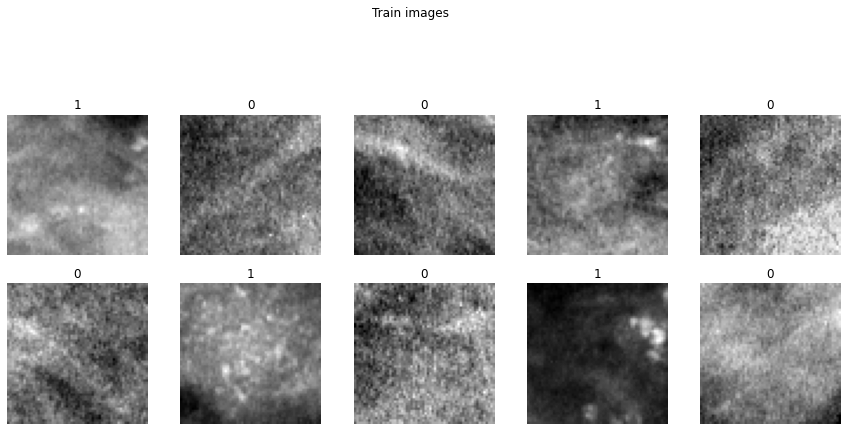

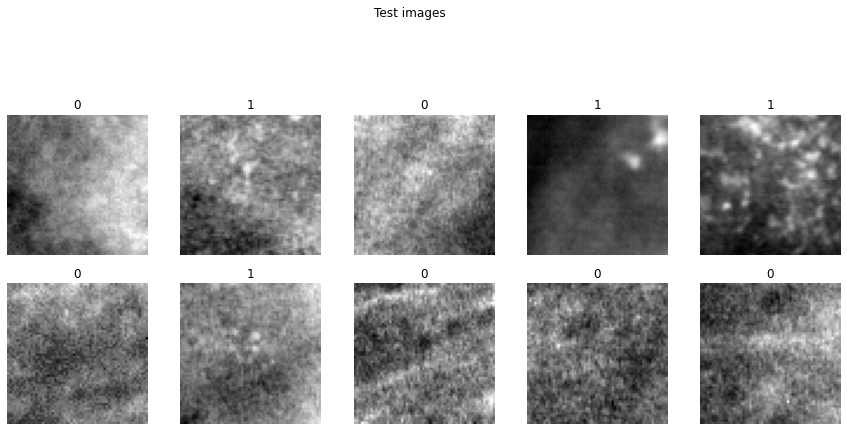

In [ ]:
# n is the number of images to visualize.
n = 10


# I need to define the number or rows and columns of the subplots based on the parity of n.
if n % 2 == 0:
  n_rows = n/2
  n_cols = n/2
else: 
  n_rows = int(round(n/2))
  n_cols = int(round(n/2)) + 1

# Creating the main figure and the subfigures of training images.
plt.figure(1, figsize = (15, 15))
plt.suptitle('Train images')
for i in range(1, n+1):
  # Choose a random index ranging from 0 to the total number of images.
  r = random.randrange(0, len(x_train))
  # Plotting the image corresponding to the chosen index
  Im = x_train[r].squeeze()
  plt.subplot(n_rows, n_cols, i)
  plt.imshow(Im, cmap = 'gray')
  plt.axis('off')
  plt.title(f'{y_train[r]}')

# The same process is repeated for some test images
plt.figure(2, figsize = (15, 15))
plt.suptitle('Test images')
for i in range(1, n+1):
  r = random.randrange(0, len(x_test))
  Im = x_test[r].squeeze()
  plt.subplot(n_rows, n_cols, i)
  plt.imshow(Im, cmap = 'gray')
  plt.axis('off')
  plt.title(f'{y_test[r]}')


#Data augmentation

##Convert all 'pgm' images format to 'png' format
(needed to run ImageDataGenerator)

In [ ]:
def convert_to_png(fname, dest_folder):
  '''Takes as input the file to convert and the destination
     folder to put the converted file in
     and converts the file from pgm to png saving it into 
     dest_folder
  '''
  
  # Creates a new folder to put the converted images in
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
    
  logger.debug('converting %s', fname)
  # Replaces the .pgm part in the filename with .png
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  # Defines the destination file path
  dest_fname = os.path.join(dest_folder, dest_fname)
  # Converts the image to grayscale and save it
  PIL.Image.open(fname).convert('L').save(dest_fname)

In [ ]:
for data_path in [os.path.join(PATH, "Train"), os.path.join(PATH, "Test")]:
  for path, folders, fnames in os.walk(data_path):
    # Using convert_to_png function to every filename (i.e. every image)
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      # Creates new folders for png images in the same path of the original pgm images
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)


Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0008s1_2_0.pgm_3.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0008s1_2_0.pgm_3.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0022t1_1_0.pgm_1.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0022t1_1_0.pgm_1.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0004s1_3_0.pgm_2.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0004s1_3_0.pgm_2.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0012n1_4_0.pgm_4.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0012n1_4_0.pgm_4.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0012n1_1_0.pgm_1.pgm
Mylogger (DEBUG): converting gdrive/MyDrive/IMAGES/Mammography_micro/Train/0/0012n1_1_0.pgm_1.pgm
Mylogger (DEBUG): co

##Data augmentation. 

*  **ImageDataGenerator**

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

*  **flow_from_directory**

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory


In [ ]:
path_to_png_data = os.path.join(PATH, "Train_png")
# Defines the shape of the images
img_width, img_height = (60, 60)

# Setting the fraction of image to use during training and validation
aug_validation_split = 0.3

''' Defining the operations to be randomly done to every input image
''' 
train_datagen = ImageDataGenerator(
    rotation_range = 45,  # <-- [Degrees] 
    height_shift_range = 0.2,
    zoom_range = 0.2,  
    rescale = 1./255,  # <-- Rescales every pixel to have a value between 0 and 1
    shear_range = 0.2, 
    fill_mode = 'reflect',# <-- Fills blank spaces reflecting the images 
    validation_split = aug_validation_split)  


''' train_gen generates a group of new images from every single image contained
    in path_to_png_data using train_datagen as a transformation function.
    The same label as the one related to the original image is given to 
    every image of the new group of images. 
    These images represent the training subset.
    Returns a DirectoryIterator yielding tuples of (group_images, related_labels)
'''       
train_gen = train_datagen.flow_from_directory(

    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',# <-- Defines the type of labels array: binary = 1D 
    subset='training') # <-- Sets the corrisponding group of images to be used as training or validation.

''' val_gen does the same thing as train_gen but the images generated
        represent the validation subset.
'''
val_gen = train_datagen.flow_from_directory(
    
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')



Found 278 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


# Defining a CNN model

Keras layers documentation: https://keras.io/api/layers/

In [ ]:
def make_model(shape=(60, 60, 1)):
  ''' Takes as input the shape of images (Default = (60, 60, 1) is the shape
      of the dataset) and returns the keras.model class.
  '''
  model = Sequential([
                      
      Conv2D(50, (5,5), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(60, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
        
      Conv2D(100, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(100, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(50, (4,4), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D(2, 2),

      Flatten(), 
      
      Dense(1, activation='sigmoid')
      
  ])
  
  return model


#Fit model on original dataset

ModelCheckpoint: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
# Sets a checkpoint to save weights giving the best performance on val_accuracy 
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


Model.compile: https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

In [ ]:
''' Defines the model and compiles it.
'''
model = make_model()
model.compile(optimizer = SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')

Model.fit: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
''' Training the model using x_train and y_train images and labels and doing a validation split of 30%
'''
val_split = 0.3

history = model.fit(x_train, y_train, 
                    validation_split=val_split, 
                    epochs=100, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=1)

In [ ]:
''' Plots loss, val_loss, accuracy and val_accuracy obtanined during the train
''' 
plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss and val_loss')

plt.figure(2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy and val_accuracy')

plt.show()

In [ ]:
# Saves the model
model.save(os.path.join(PATH, 'model.hdf5'))
''' Evaluates performances of the model 
    calculating 'loss' and 'metrics' (accuracy in our case)
'''
model.evaluate(x_test, y_test) 


13/13 [==============================] - 0s 10ms/step - loss: 0.8201 - accuracy: 0.7581


[0.820101797580719, 0.7581047415733337]

# Fit model on augmented dataset

Similarly to the block above, now the training is performed on augmented dataset. This block can be run indipendently from the previous.

In [ ]:
checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


In [ ]:
''' Defining the model, compiling and training it
'''
model = make_model()

model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

batch_size=32

# Defines the number of images to do training on
Tot_train_imgs = len(x_train)

# Defines the number of steps to do in each epoch
steps_per_epoch = int(Tot_train_imgs * (1- aug_validation_split))

# Defines the total number of samples to create for validation
validation_steps = int(Tot_train_imgs * aug_validation_split)

logger.info('Steps per epoch = %d', steps_per_epoch)
logger.info('Val steps = %d', validation_steps)

history = model.fit(
        train_gen,
        steps_per_epoch = steps_per_epoch // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps= validation_steps // batch_size,
        verbose=1,
        callbacks=[checkpoint])

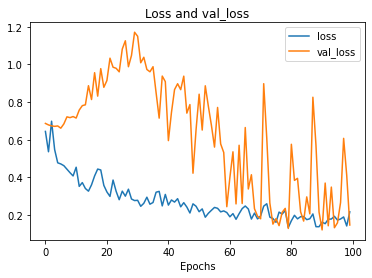

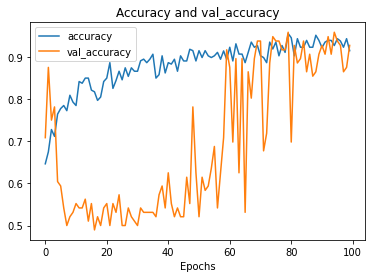

In [ ]:
''' Plots loss, val_loss, accuracy and val_accuracy obtanined during the train
''' 
plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')

plt.title('Loss and val_loss')

plt.figure(2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy and val_accuracy')
plt.show()

In [ ]:
''' Saving and evaluating the model
'''
model.save(os.path.join(PATH, 'model_augmented.hdf5'))

model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 6ms/step - loss: 0.3660 - accuracy: 0.8953


[0.3660229742527008, 0.895261824131012]

# Comparing the performances of the two trainings

In [ ]:
noaug_model = load_model(os.path.join(PATH, 'model.hdf5'))
aug_model = load_model(os.path.join(PATH, 'model_augmented.hdf5'))

In [ ]:
noaug_model.evaluate(x_test, y_test)
aug_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 6ms/step - loss: 0.3660 - accuracy: 0.8953


[0.3660229742527008, 0.895261824131012]

#*Testing model on wavelet-filtered images*

Now the training is performed on wavelet filtered dataset with the same model and optimizer. This block can be run independently from the training blocks above.

##Define the path and the wavelet type

In [ ]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets'

In [ ]:
# Prints all the wavelet families which have been used to filter the original images
print('Wavelet familes:')
for i, wavelet_type in enumerate(os.listdir(PATH)):
  print(f'{i}. {wavelet_type}')

Wavelet familes:
0. sym2_3levels_nodenoise
1. db2_3levels_nodenoise
2. db2_3levels_yesdenoise
3. db5_4levels_yesdenoise
4. sym2_3levels_yesdenoise
5. db5_4levels_nodenoise


In [ ]:
# Choose a wavelet family
wavelet_type = 'sym2_3levels_nodenoise'

##Reading the images applying read_img function

In [ ]:
# Defines the path to the sub-folder of Train images folder containing breast mammograms without microcalcifications
image_path = os.path.join(PATH, wavelet_type,'Train/0')
# Creates the test images and labels array with read_img function
x0_train, y0_train = read_img(image_path)


# Defines the path to the sub-folder of Train images folder containing breast mammograms with microcalcifications.
image_path = os.path.join(PATH, wavelet_type,'Train/1')
# Creates the test images and labels array with read_img function.
x1_train, y1_train = read_img(image_path)

# Create an array with both 0 labelled and 1 labelled images and and an array containing all the labels.
x_train = np.concatenate((x0_train, x1_train), axis = 0)
y_train = np.concatenate((y0_train, y1_train))

# Does the same as before on the Test folder.
image_path = os.path.join(PATH, wavelet_type, 'Test/0')
x0_test, y0_test = read_img(image_path)

image_path = os.path.join(PATH,  wavelet_type,'Test/1')
x1_test, y1_test = read_img(image_path)

x_test = np.concatenate((x0_test, x1_test), axis = 0)
y_test = np.concatenate((y0_test, y1_test))

# Prints the total number of images found.
print(f'There are {len(x_train)} train images and {len(x_test)} test images')


# Concatenates train and test images in a single array and do the same on train and test labels arrays. 
X_tot = np.concatenate((x_train, x_test), axis=0)
Y_tot = np.concatenate((y_train, y_test), axis=0)

Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/sym2_3levels_nodenoise/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/sym2_3levels_nodenoise/Train/0: 209
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/sym2_3levels_nodenoise/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/sym2_3levels_nodenoise/Train/1: 187
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/sym2_3levels_nodenoise/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/sym2_3levels_nodenoise/Test/0: 205
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/sym2_3levels_nodenoise/Test/1: 196
Mylogger (INFO): Num images found in gdrive/MyDrive/IMAGES/Mammography_micro/Wavelets/sym2_3levels_nodenoise/Test/1: 196


There are 396 train images and 401 test images


##Training and eveluate the model

In [ ]:
# Set a checkpoint to save weights giving the best performance on val_accuracy 
checkpoint = ModelCheckpoint(
    "model_on_wavelets-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [ ]:
model = make_model()

model.compile(optimizer = SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')

In [ ]:
history = model.fit(x_train, y_train, 
                    validation_split=0.3, 
                    epochs=100, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=1)

Epoch 1/100
10/10 [==============================] - 1s 41ms/step - loss: 0.5667 - accuracy: 0.8338 - val_loss: 0.7622 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to model_on_wavelets-01-0.00.hdf5
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 0.1691 - accuracy: 0.9272 - val_loss: 0.9504 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 0.1185 - accuracy: 0.9544 - val_loss: 1.1604 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0683 - accuracy: 0.9699 - val_loss: 1.4046 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/100
10/10 [==============================] - 0s 18ms/step - loss: 0.0543 - accuracy: 0.9740 - val_loss: 1.5552 - val_accuracy: 0.0000e+

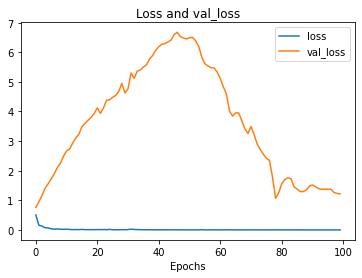

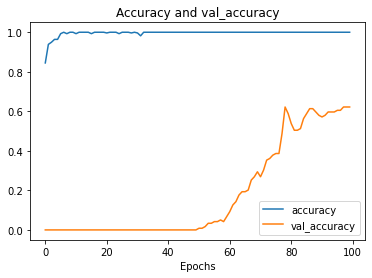

In [ ]:
''' Plots loss, val_loss, accuracy and val_accuracy obtanined during the train
''' 
plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss and val_loss')

plt.figure(2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy and val_accuracy')
plt.show()

In [ ]:
# calculates 'loss' and 'metrics' (accuracy in our case)
model.evaluate(x_test, y_test) 

13/13 [==============================] - 0s 6ms/step - loss: 0.5174 - accuracy: 0.8404


[0.5174192786216736, 0.8403990268707275]

#Implement a cross-validation test

It can be run both for original dataset and for wavelet-filtered dataset.

KFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In folder 1: loss of 0.1519128531217575 - accuracy of 0.8999999761581421
In folder 2: loss of 0.18485987186431885 - accuracy of 0.949999988079071
In folder 3: loss of 0.10964503139257431 - accuracy of 0.9624999761581421
In folder 4: loss of 0.06862467527389526 - accuracy of 0.9750000238418579
In folder 5: loss of 0.12277282774448395 - accuracy of 0.949999988079071
In folder 6: loss of 0.12620197236537933 - accuracy of 0.9375
In folder 7: loss of 0.21724815666675568 - accuracy of 0.925000011920929
In folder 8: loss of 0.2422475963830948 - accuracy of 0.9367088675498962
In folder 9: loss of 0.5166090130805969 - accuracy of 0.8607594966888428
In folder 10: loss of 0.08593679964542389 - accuracy of 0.9746835231781006


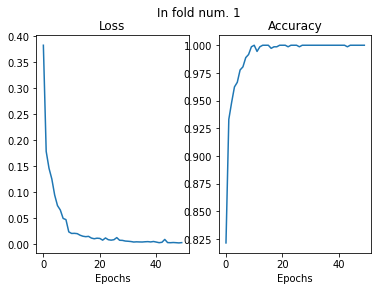

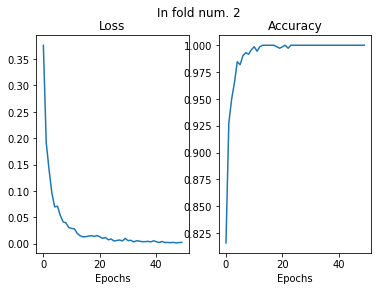

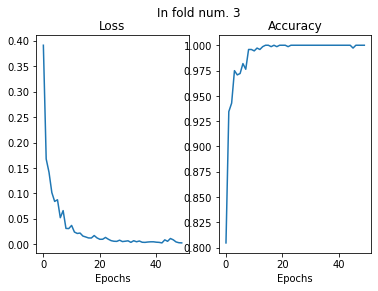

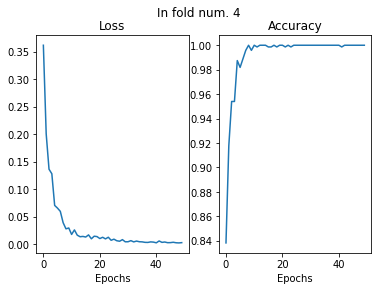

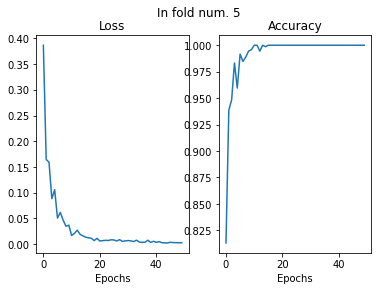

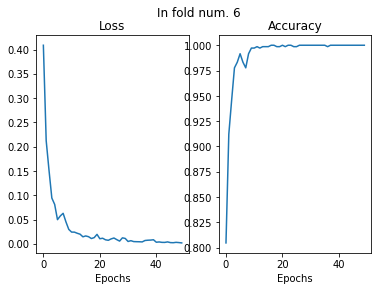

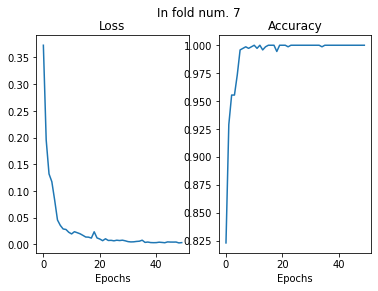

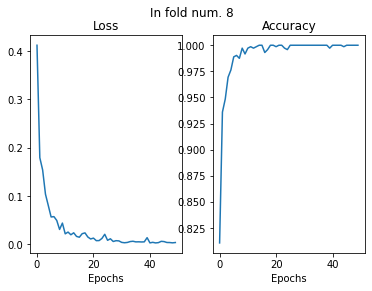

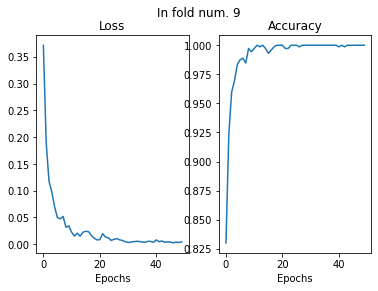

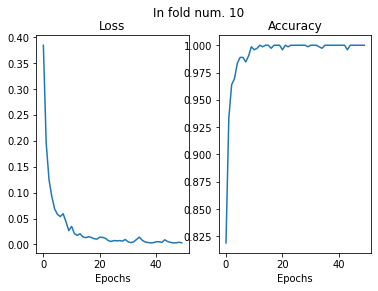

In [ ]:
# Defines per-fold accuracy and loss arrays
acc_per_fold = []
loss_per_fold = []

# Defines the number of folds to split dataset on
num_folds = 10
# Defining the function kfold whic is used to split the dataset
kfold = KFold(n_splits = num_folds, shuffle=True)

batch_size = 32
num_epochs = 50

fold_num = 1

# Defines the model and compiles it
model = make_model()
model.compile(optimizer=SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')
# Saves the weights before training to let them be reset before each training
model.save_weights('reset_model.h5')

for train, test in kfold.split(X_tot, Y_tot):
  ''' Training the model and test it for every fold created 
      from the total original dataset
  '''
  # Reset the untrained model weights saved before 
  model.load_weights('reset_model.h5')
  # Fitting the model using every folder (but one) as training
  history = model.fit(
          X_tot[train], Y_tot[train],
          batch_size = batch_size,
          verbose=0,
          epochs = num_epochs)  
  
  # Evaluates the efficiency of the model
  scores = model.evaluate(X_tot[test], Y_tot[test], verbose=0)
  # Printing the results of the training
  print(f'In folder {fold_num}: {model.metrics_names[0]} of {scores[0]} - {model.metrics_names[1]} of {scores[1]}')
  

  # Plots loss and accuracy obtanined during the train for each fold  
  plt.figure(fold_num)
  plt.suptitle(f'In fold num. {fold_num}')
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.plot(history.history['loss'])
  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.plot(history.history['accuracy'])

  # Putting scores on to the corrisponding list to calculate the mean value ot them at the end
  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  fold_num += 1

In [ ]:
# Computing and printing average scores
print('Average scores for all folds:')
print(f'-- Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# Calculates loss error as maximum value error
err_loss = (max(loss_per_fold)-min(loss_per_fold))/2
print(f'-- Loss: {np.mean(loss_per_fold)} +/- {err_loss}')

Average scores for all folds:
-- Accuracy: 0.9372151851654053 (+- 0.033433195225939565)
-- Loss: 0.18260587975382805 +/- 0.22399216890335083
